In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import copy
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from keras import backend as K 
import gensim
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# path_cnn= '/content/drive/My Drive/Colab Notebooks/data/processedID_cnn_dataset.pkl'
path_cnn= '/content/drive/My Drive/Colab Notebooks/data/train_dataset.pkl'

stories = pickle.load(open(path_cnn, 'rb'))
print("total number of CNN data: ",len(stories))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total number of CNN data:  301956


In [ ]:
index_story = 0
sample_story = stories[index_story]
count_ws =0
for sentence in sample_story['story']:
  for word in sentence.split(' '):
    count_ws += 1
print("# word in story {}: {}".format(index_story,count_ws))

count_h, count_wh = 0,0
for highlight in sample_story['highlights']:
  count_h += 1
  for word in highlight.split(' '):
    count_wh += 1
print("# hightlights of story {}: {}".format(index_story,count_h))
print("# word in all hightlights of story {}: {}".format(index_story,count_wh))
print()
stories[1]

# word in story 0: 473
# hightlights of story 0: 3
# word in all hightlights of story 0: 35



{'highlights': ['arizona judge rules for group trying to stop school districts mexicanamerican studies',
  'ruben navarrette latinoamerican population is growing its fair to teach its history',
  'arizona has approved a series of oppressive measures he says including immigration law',
  'these measures are championed by people afraid of changing demographics he writes'],
 'id': 'id_cnn_66720',
 'story': ['arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cultural footprint',
  'were talking about courses in mexicanamerican history being taught to high school students of all colors and backgrounds in the tucson unified school district',
  'concerned that teachers are presenting material in a biased and inflammatory manner a posse of elected officials education bureaucrats and school board trustees made up of democrats and republicans are trying t

In [ ]:

# number of highlights to be used
NUM_HIGHLIGHT= 1
# number of storie sentences to be used
NUM_STORY = 2

# join sentence in both stories and highlights together for each data sample
processed_stories = copy.deepcopy(stories)

# join stories and highlights into 2 column pd dataframe
for each_story in processed_stories:
  # join highlights
  each_story['highlights'] = ' '.join(each_story['highlights'][0:NUM_HIGHLIGHT])
  # join story sentences
  each_story['story'] = ' '.join(each_story['story'][0:NUM_STORY])


stories[2],processed_stories[2]

({'highlights': ['northwestern university football players vote friday on whether to unionize',
   'supporters say athletes who generate huge money for schools deserve protections',
   'vote result wont be known until after national labor relations board reviews case'],
  'id': 'id_cnn_91222',
  'story': ['northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment',
   'but the result of the vote might not be known for months',
   'the national labor relations board allowed the vote after its chicago office ruled in march that northwestern football players can unionize deeming them school employees because of the hours they put in the control the university has over them and the revenue they generate',
   'however northwestern asked the nrlb for a review and the nlrb said the results of fridays vote wont be made public until that is finished the review

In [ ]:
# join stories and highlights into 2 column pd dataframe
df_cnn = pd.DataFrame(processed_stories)
print(df_cnn.iloc[1,0])
print(df_cnn.iloc[1,1])

df_cnn

arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cultural footprint were talking about courses in mexicanamerican history being taught to high school students of all colors and backgrounds in the tucson unified school district
arizona judge rules for group trying to stop school districts mexicanamerican studies


,story,highlights,id
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168
...,...,...,...
301951,newcastle legend alan shearer has slammed the club for a lack of ambition under the tenure of owner mike ashley the magpies are in the premier league table having escaped with a win over relegatio...,newcastle are currently in the premier league table,id_dm_175879
301952,the mayor of two romanian villages has claimed that up to half of their residents will move to the uk when restrictions are lifted in january koller gabrieladrian said he believed per of the peopl...,remus neda is heading for the uk to take advantage of state handouts,id_dm_29988
301953,the health of pope emeritus benedict xvi has deteriorated the vatican has revealed senior church officials were forced to make their fears public after a respected vatican expert declared we wont ...,respected vatican expert sparks fears for pope emerituss health,id_dm_162103
301954,like the moment that harry potter first learned he was a wizard raleigh browne can vividly recall when he first heard of the adventures of the boy who lived it was the summer between my kindergart...,many ireporters feel a kinship to harry potter having literally grown up with the character,id_cnn_27915


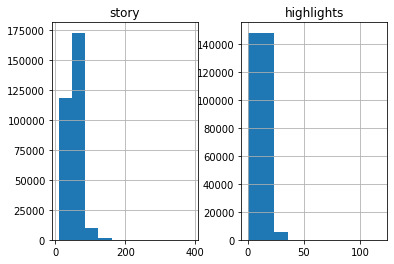

In [ ]:

text_count = []
summary_count = []
for sent in df_cnn['story']:
    text_count.append(len(sent.split()))
for sent in df_cnn['highlights']:
    summary_count.append(len(sent.split()))

graph_df= pd.DataFrame()
graph_df['story']=text_count
graph_df['highlights']=summary_count


graph_df.hist(bins = 10)
plt.show()

# sns.displot(df_cnn, x="story", binwidth=10)
# sns.displot(df_cnn, x="highlights", binwidth=10)



In [ ]:
def count_perc_words(df,col_name='story',len_start=0,len_end=15):
  #Check how much % of summary have ... number of words.
  count=0
  for sentence in df_cnn[col_name]:
      num_word = len(sentence.split()) 
      if  (num_word >= len_start) and (num_word < len_end):
          count=count+1
  return (count/len(df_cnn[col_name]))

# print("% of story have 0 to 500 words =",count_perc_words(df_cnn,'story',0,500))
# print("% of story have 500 to 1000 words =",count_perc_words(df_cnn,'story',500,1000))
# print("% of story have 1000 to 1500 words =",count_perc_words(df_cnn,'story',1000,1500))
# print("% of story have more than 1500 words =",count_perc_words(df_cnn,'story',1500,9900))

# print("% of highlight have 0 to 50 words =",count_perc_words(df_cnn,'highlights',0,50))
# print("% of highlight have 50 to 100 words =",count_perc_words(df_cnn,'highlights',50,100))
# print("% of highlight have more than 100 words =",count_perc_words(df_cnn,'highlights',100,9900))



In [ ]:

#Shorten the Summaries and Text between max len defined above
def count_word(sentence):
  return len(sentence.split(' '))

# count #word in highlight/summary
df_cnn['num_word_highlights'] = df_cnn.apply(lambda row: count_word(row['highlights']), axis=1)
# count #word in story
df_cnn['num_word_story'] = df_cnn.apply(lambda row: count_word(row['story']), axis=1)

print('max num_word_highlights:',max(df_cnn['num_word_highlights']),'max num_word_story:',max(df_cnn['num_word_story']))
print('mean num_word_highlights:',np.mean(df_cnn['num_word_highlights']),'max num_word_story:',np.mean(df_cnn['num_word_story']))
print('median num_word_highlights:',np.median(df_cnn['num_word_highlights']),'max num_word_story:',np.median(df_cnn['num_word_story']))


df_cnn.head(10)

max num_word_highlights: 118 max num_word_story: 388
mean num_word_highlights: 12.434069864483567 max num_word_story: 53.13195631151559
median num_word_highlights: 12.0 max num_word_story: 51.0


,story,highlights,id,num_word_highlights,num_word_story
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548,10,46
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720,12,58
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222,10,41
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005,13,36
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168,9,61
5,hull boss steve bruce believes any side he chooses to field against lokeren will be capable of overturning a deficit in their europa league playoff second leg but has urged his players to show pat...,steve bruce confident hull can overcome lokeren in europa league playoff,id_dm_58746,11,68
6,a woman was so distracted checking facebook on her cell phone that she drove into the back of another vehicle on a north dakota highway and killed an greatgrandmother prosecutors say abby sletten ...,abby sletten was charged with negligent homicide on wednesday,id_dm_140948,9,56
7,the squeaky clean star of high school musical so zac fans will be shocked to hear how he secretly completed a stint in rehab five months ago according to tmz the actor quietly checked into a treat...,actor secretly checked into a treatment facility five months ago,id_dm_148987,10,68
8,it seems these two real estate agents saved their dirty tricks for the bedroom coldwell banker realtors robert lindsay and jeannemarie phelan have allegedly been caught on camera having sex numero...,new jerseys richard and sandra weiner are suing two real estate agents who they claim intentionally overpriced their home so they could use it as a play pad to have sexual relations,id_dm_69988,32,47
9,cap british restaurateur rekha patel cradled her newborn daughter at the akanksha clinic in northwestern india as her husband daniel smiled,only a handful of countries allow women to make money from surrogacy,id_dm_173114,12,21


In [ ]:
MAX_LEN_TEXT=100
MAX_LEN_SUM=30

MIN_LEN_TEXT = 10
MIN_LEN_SUM = 5

df_cnn=df_cnn[ (df_cnn['num_word_highlights']>MIN_LEN_SUM) & (df_cnn['num_word_highlights']<=MAX_LEN_SUM) \
             & (df_cnn['num_word_story']>MIN_LEN_TEXT) & (df_cnn['num_word_story']<=MAX_LEN_TEXT)]

df_cnn

,story,highlights,id,num_word_highlights,num_word_story
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548,10,46
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720,12,58
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222,10,41
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005,13,36
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168,9,61
...,...,...,...,...,...
301950,wales begin their rbs nations campaign with a mouthwatering clash against england on friday night the two rivals will go headtohead at the millennium stadium in cardiff a city that has thrown up s...,wales largestever win against england came in a victory in,id_dm_101238,10,39
301951,newcastle legend alan shearer has slammed the club for a lack of ambition under the tenure of owner mike ashley the magpies are in the premier league table having escaped with a win over relegatio...,newcastle are currently in the premier league table,id_dm_175879,8,40
301952,the mayor of two romanian villages has claimed that up to half of their residents will move to the uk when restrictions are lifted in january koller gabrieladrian said he believed per of the peopl...,remus neda is heading for the uk to take advantage of state handouts,id_dm_29988,13,58
301953,the health of pope emeritus benedict xvi has deteriorated the vatican has revealed senior church officials were forced to make their fears public after a respected vatican expert declared we wont ...,respected vatican expert sparks fears for pope emerituss health,id_dm_162103,9,39


In [ ]:
# put _START_ and _END_ tokens at shorten_highlights
df_cnn.loc[:,'shorten_highlights']= df_cnn['highlights']
df_cnn.loc[:,'shorten_story']= df_cnn['story']

df_cnn['shorten_highlights'] = '_START_ '+df_cnn['shorten_highlights'].astype(str)+' _END_'
df_cnn

,story,highlights,id,num_word_highlights,num_word_story,shorten_highlights,shorten_story
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548,10,46,_START_ controversial leader collapsed on thursday but could not be saved _END_,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720,12,58,_START_ arizona judge rules for group trying to stop school districts mexicanamerican studies _END_,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222,10,41,_START_ northwestern university football players vote friday on whether to unionize _END_,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005,13,36,_START_ of eu meeting mugabe said there was no animosity it was quite friendly _END_,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168,9,61,_START_ lionel messi continues his incredible scoring spree for barcelona _END_,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...
...,...,...,...,...,...,...,...
301950,wales begin their rbs nations campaign with a mouthwatering clash against england on friday night the two rivals will go headtohead at the millennium stadium in cardiff a city that has thrown up s...,wales largestever win against england came in a victory in,id_dm_101238,10,39,_START_ wales largestever win against england came in a victory in _END_,wales begin their rbs nations campaign with a mouthwatering clash against england on friday night the two rivals will go headtohead at the millennium stadium in cardiff a city that has thrown up s...
301951,newcastle legend alan shearer has slammed the club for a lack of ambition under the tenure of owner mike ashley the magpies are in the premier league table having escaped with a win over relegatio...,newcastle are currently in the premier league table,id_dm_175879,8,40,_START_ newcastle are currently in the premier league table _END_,newcastle legend alan shearer has slammed the club for a lack of ambition 

In [ ]:
# add sostok and eostok (token) to shorten_highlights
df_cnn['shorten_highlights'] = df_cnn.apply(lambda row : 'sostok '+ row['shorten_highlights'] + ' eostok',axis=1)

df_cnn.head(5)

,story,highlights,id,num_word_highlights,num_word_story,shorten_highlights,shorten_story
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548,10,46,sostok _START_ controversial leader collapsed on thursday but could not be saved _END_ eostok,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720,12,58,sostok _START_ arizona judge rules for group trying to stop school districts mexicanamerican studies _END_ eostok,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222,10,41,sostok _START_ northwestern university football players vote friday on whether to unionize _END_ eostok,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005,13,36,sostok _START_ of eu meeting mugabe said there was no animosity it was quite friendly _END_ eostok,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168,9,61,sostok _START_ lionel messi continues his incredible scoring spree for barcelona _END_ eostok,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...


In [ ]:
print(df_cnn.loc[2,'shorten_story'])
print(df_cnn.loc[20,'shorten_story'])
df_cnn.loc[2,'shorten_highlights'],df_cnn.loc[20,'shorten_highlights']


northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment but the result of the vote might not be known for months
this is the bizarre sight of thousands of videos which have been dumped on farmland by suspected flytippers the unwanted collection of tapes includes everything from james bond through to bob the builder and a carol vorderman fitness video


('sostok _START_ northwestern university football players vote friday on whether to unionize _END_ eostok',
 'sostok _START_ tapes include everything from bob the builder through to james bond _END_ eostok')

In [ ]:
X_train,X_vali,Y_train,Y_vali=train_test_split(np.array(df_cnn['shorten_story']),np.array(df_cnn['shorten_highlights']),train_size=0.90,random_state=0,shuffle=False)
X_train.shape, X_vali.shape, Y_train.shape, Y_vali.shape
# train/val: 266182, 29576 , total = 295758


((266182,), (29576,), (266182,), (29576,))

In [ ]:
%%time

#prepare a tokenizer for reviews on training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

threshold=4

count=0
total_count=0
frequency=0
total_freq=0

for key,value in X_tokenizer.word_counts.items():
    total_count += 1
    total_freq += value
    if(value < threshold):
        count=count+1
        frequency=frequency+value
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_freq)*100)

#prepare a tokenizer for reviews on training data
X_tokenizer = Tokenizer(num_words=total_count-count) 
X_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train) 
X_vali_seq   =   X_tokenizer.texts_to_sequences(X_vali)

#padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen=MAX_LEN_TEXT, padding='post')
X_vali   =   pad_sequences(X_vali_seq, maxlen=MAX_LEN_TEXT, padding='post')

#size of vocabulary ( +1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(X_voc))

% of rare words in vocabulary: 65.46420101055237
Total Coverage of rare words: 1.1496141966465028
Size of vocabulary in X = 60286
CPU times: user 41.2 s, sys: 167 ms, total: 41.4 s
Wall time: 41.4 s


In [ ]:
%%time
Y_tokenizer = Tokenizer()   
Y_tokenizer.fit_on_texts(list(Y_train))

threshold=6

count=0
total_count=0
frequency=0
total_freq=0

for key,value in Y_tokenizer.word_counts.items():
    total_count += 1
    total_freq += value
    if(value < threshold):
        count += 1
        frequency += value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_freq)*100)

#prepare a tokenizer for reviews on training data
Y_tokenizer = Tokenizer(num_words=total_count-count) 
Y_tokenizer.fit_on_texts(list(Y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
Y_train_seq    =   Y_tokenizer.texts_to_sequences(Y_train)
Y_vali_seq   =   Y_tokenizer.texts_to_sequences(Y_vali) 

#padding zero upto maximum length
Y_train    =   pad_sequences(Y_train_seq, maxlen=MAX_LEN_SUM, padding='post')
Y_vali   =   pad_sequences(Y_vali_seq, maxlen=MAX_LEN_SUM, padding='post')

#size of vocabulary
Y_voc  =   Y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(Y_voc))

% of rare words in vocabulary: 76.24843699448249
Total Coverage of rare words: 3.3273843982612212
Size of vocabulary in Y = 27164
CPU times: user 17.4 s, sys: 164 ms, total: 17.6 s
Wall time: 17.6 s


In [ ]:
# We will now remove "Summary" i.e Y (both train and val) which has only START and END
idx=[]
for i in range(len(Y_train)):
    count=0
    for j in Y_train[i]:
        if j != 0:
            count += 1
    if(count == 2):
        idx.append(i)

Y_train=np.delete(Y_train,idx, axis=0)
X_train=np.delete(X_train,idx, axis=0)

idx=[]
for i in range(len(Y_vali)):
    count=0
    for j in Y_vali[i]:
        if j != 0:
            count += 1
    if(count == 2):
        idx.append(i)

Y_vali=np.delete(Y_vali,idx, axis=0)
X_vali=np.delete(X_vali,idx, axis=0)

In [ ]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0


BaseException: ignored

In [ ]:
print("Size of vocabulary from the w2v model = {}".format(X_voc))

K.clear_session()


Size of vocabulary from the w2v model = 60286


In [ ]:
latent_dim = 300
embedding_dim=200

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU

  # Encoder
  encoder_inputs = Input(shape=(MAX_LEN_TEXT,))

  #embedding layer
  enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  # encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)

  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  # encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)

  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  # encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)

  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(Y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  # decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)

  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(Y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model 
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     12057200    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [ ]:

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [ ]:
%%time
## fitting with TPU
# history=model.fit([X_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=100,callbacks=[es],batch_size=512 * tpu_strategy.num_replicas_in_sync, validation_data=([X_vali,Y_vali[:,:-1]], Y_vali.reshape(Y_vali.shape[0],Y_vali.shape[1], 1)[:,1:]))

## fitting with CPU/GPU
# history=model.fit([X_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=32, validation_data=([X_vali,Y_vali[:,:-1]], Y_vali.reshape(Y_vali.shape[0],Y_vali.shape[1], 1)[:,1:]))

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/65 [..............................] - ETA: 8s - loss: 10.1878WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.2599s). Check your callbacks.


65/65 [==============================] - ETA: 0s - loss: 4.1660WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0818s). Check your callbacks.


65/65 [==============================] - 31s 480ms/step - loss: 4.1660 - val_loss: 3.3217
Epoch 2/100
65/65 [==============================] - 18s 279ms/step - loss: 3.2518 - val_loss: 3.1213
Epoch 3/100
65/65 [==============================] - 18s 277ms/step - loss: 3.1171 - val_loss: 3.0455
Epoch 4/100
65/65 [==============================] - 18s 278ms/step - loss: 3.0594 - val_loss: 2.9964
Epoch 5/100
65/65 [==============================] - 18s 276ms/step - loss: 2.9948 - val_loss: 2.9218
Epoch 6/100
65/65 [==============================] - 18s 277ms/step - loss: 2.9228 - val_loss: 2.8610
Epoch 7/100
65/65 [==============================] - 18s 277ms/step - loss: 2.8652 - val_loss: 2.8150
Epoch 8/100
65/65 [==============================] - 18s 276ms/step - loss: 2.8163 - val_loss: 2.7715
Epoch 9/100
65/65 [==============================] - 18s 277ms/step - loss: 2.7679 - val_loss: 2.7215
Epoch 10/100
65/65 [==============================] - 18s 278ms/step - loss: 2.7185 - val_loss

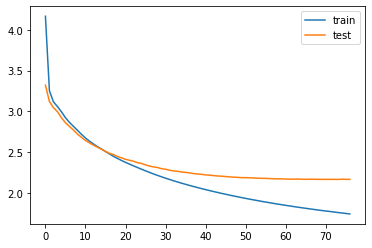

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:

# # save loss into json for later plotting

# list all data in history
print(history.history.keys())
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history

# Save it under the form of a json file
# json.dump(history_dict, open(save_loc+'/history_loss.json', 'w'))


# load history
# history_dict = json.load(open(save_loc+'/history_loss.json', 'r'))
# history_dict

dict_keys(['loss', 'val_loss'])


In [ ]:
reverse_target_word_index=Y_tokenizer.index_word
reverse_source_word_index=X_tokenizer.index_word
target_word_index=Y_tokenizer.word_index

In [ ]:
#### LOAD MODELS #######
from keras.models import model_from_json
save_loc = '/content/drive/My Drive/Colab Notebooks/data/trained_seq2seq_model'

def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

encoder_model = load_model(save_loc+'/encoder_model.json', save_loc+'/encoder_model_weights.h5')
decoder_model = load_model(save_loc+'/decoder_model.json', save_loc+'/decoder_model_weights.h5')

In [ ]:

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN_TEXT,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

NameError: ignored

In [ ]:
###### SAVE models and weights ######

# # https://stackoverflow.com/questions/48158547/restore-keras-seq2seq-model
# save_loc = '/content/drive/My Drive/Colab Notebooks/data'
# with open(save_loc+'/encoder_model.json', 'w', encoding='utf8') as f:
#     f.write(encoder_model.to_json())
# encoder_model.save_weights(save_loc+'/encoder_model_weights.h5')

# with open(save_loc+'/decoder_model.json', 'w', encoding='utf8') as f:
#     f.write(decoder_model.to_json())
# decoder_model.save_weights(save_loc+'/decoder_model_weights.h5')

In [ ]:

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (MAX_LEN_SUM-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence
    
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
# encoder_model.summary(), decoder_model.summary(), model.summary()

In [ ]:
%%time
for i in range(0,20):
# for i in tqdm(range(0,10000)):

    # print("Review:",seq2text(X_train[i]))
    # print("Original summary:",seq2summary(Y_train[i]))
    # print("Predicted summary:",decode_sequence(X_train[i].reshape(1,MAX_LEN_TEXT)))
    # print("\n")
    print("Review:",seq2text(X_vali[i]))
    print("Original summary:",seq2summary(Y_vali[i]))
    print("Predicted summary:",decode_sequence(X_vali[i].reshape(1,MAX_LEN_TEXT)))
    print("\n")


print(len(X_train))

Review: lawsuit minneapolis priest michael keating pictured is being sued for allegedly sexually abusing a girl for three years a decade and a half ago a minneapolis priest sent at least seductive emails confessing his love to a teenage girl who he was allegedly sexually abusing for a period of three years a ago 
Original summary: start the victim who was when the alleged abuse started and is in her late now filed a lawsuit against twin cities minnesota reverend michael jerome keating monday end 
Predicted summary:  start michael hall was found guilty of sexual abuse of sexual abuse end


Review: aaron hernandez was destined to be a football superstar and was already one of the nfls most promising tight ends but less than a year after signing a million contract extension with the football powerhouse new england patriots he was charged with firstdegree murder 
Original summary: start aaron hernandez former football star is behind bars facing three murder charges end 
Predicted summary: 

In [ ]:

def decode_sequence2(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model_.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model_.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (MAX_LEN_SUM-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence
    
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
%%time
for i in range(1000,1020):
# for i in tqdm(range(0,10000)):

    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(Y_train[i]))
    print("Predicted summary:",decode_sequence2(X_train[i].reshape(1,MAX_LEN_TEXT)))
    print("\n")
    # decode_sequence(x_tr[i].reshape(1,max_text_len))

print(len(X_train))

Review: syrian rebels prepare to unleash their latest improvised weapon in their desperate struggle against the assad regime a homemade rocket launcher constructed from salvaged pipe firing projectiles made from domestic gas canisters the conflict which has been raging for two years and nine months has seen fighters from the free syria army deploying increasingly effective weapons against the far better equipped government forces 
Original summary: start improvised device fires made from domestic gas canisters end 
Predicted summary:  start syrian rebels have been targeted by isis militants in syria end


Review: with its own private beach and tranquil surroundings this norwegian house is up for sale for just there is a condition however for any prospective buyer they must focus their efforts into restoring the ramshackle property to its former glory 
Original summary: start the home is located on the island of on the of the arctic circle end 
Predicted summary:  start the property in 

In [ ]:
# from keras.models import model_from_json

# def load_model(model_filename, model_weights_filename):
#     with open(model_filename, 'r', encoding='utf8') as f:
#         model = model_from_json(f.read())
#     model.load_weights(model_weights_filename)
#     return model

# encoder_ = load_model(save_loc+'/encoder_model.json', save_loc+'/encoder_model_weights.h5')
# decoder_ = load_model(save_loc+'/decoder_model.json', save_loc+'/decoder_model_weights.h5')

In [ ]:
history.history


{'loss': [4.165976524353027,
  3.251847743988037,
  3.1170897483825684,
  3.059441566467285,
  2.9947807788848877,
  2.922792434692383,
  2.8652327060699463,
  2.8162684440612793,
  2.7678956985473633,
  2.7184998989105225,
  2.674139976501465,
  2.635169267654419,
  2.600064992904663,
  2.5673675537109375,
  2.5376534461975098,
  2.5083651542663574,
  2.4776694774627686,
  2.4490396976470947,
  2.4228129386901855,
  2.3982043266296387,
  2.3750851154327393,
  2.353367805480957,
  2.3321690559387207,
  2.3113410472869873,
  2.290792226791382,
  2.271045684814453,
  2.251676082611084,
  2.232870101928711,
  2.215169668197632,
  2.1979012489318848,
  2.1810829639434814,
  2.1651172637939453,
  2.149549722671509,
  2.13446044921875,
  2.119769811630249,
  2.1057803630828857,
  2.0919179916381836,
  2.07859206199646,
  2.065929651260376,
  2.0531294345855713,
  2.04081392288208,
  2.029024362564087,
  2.0172107219696045,
  2.0061230659484863,
  1.9945460557937622,
  1.9840612411499023,
  1